In [1]:
import torch
import nibabel as nib
import os
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np
import time
from tqdm.auto import tqdm
import utils as utils

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_current_path(path=None):
    if path:
        return path
    else:
        return os.getcwd()

if not os.path.exists(f'{get_current_path()}/data_npy'):
    os.mkdir(f'{get_current_path()}/data_npy')
    
if not os.path.exists(f'{get_current_path()}/data_npy/train'):
    os.mkdir(f'{get_current_path()}/data_npy/train')
    
if not os.path.exists(f'{get_current_path()}/data_npy/valid'):
    os.mkdir(f'{get_current_path()}/data_npy/valid')
    
if not os.path.exists(f'{get_current_path()}/data_npy/test'):
    os.mkdir(f'{get_current_path()}/data_npy/test')
    

def make_img_path(cid, which='train'):
    case_id = f"case_{cid}"
    root = os.path.join(get_current_path(), 'data_npy', which, case_id)
    if not os.path.exists(root): 
        os.mkdir(root)
    root = os.path.join(root,'imaging')
    if not os.path.exists(root): 
        os.mkdir(root)
    return root
    # return os.path.join(root,'imaging.nii.gz')

def make_seg_path(cid, which='train'):
    case_id = f"case_{cid}"
    root = os.path.join(get_current_path(), 'data_npy', which, case_id)
    if not os.path.exists(root): 
        os.mkdir(root)
    root = os.path.join(root,'segmentation')
    if not os.path.exists(root): 
        os.mkdir(root)
    return root
    # return os.path.join(root,'segmentation.nii.gz')

In [39]:
def perform_image_slicing(root_path, which):
    depth_list = []
    for file_name in tqdm(os.listdir(root_path)):
        if file_name.endswith('.nii.gz'):
            img_id = str(file_name.split('_')[1])
            img = nib.load(os.path.join(root_path, file_name)).get_fdata()
            # normalizing the image between 0 and 1
            img=(img-img.min())/(max((img.max()-img.min()),1e-3))
            depth = img.shape[2]
            depth_list.append(depth)
            for j in range(depth):
                new_path=os.path.join(make_img_path(img_id, which=which), '{:04d}.npy'.format(j))
                new_img = torch.tensor(img[:, :, j:j+1].astype(np.float32))
                new_img = new_img.permute(2, 0, 1)
                new_img = np.array(new_img)
                np.save(new_path, new_img)
        
    return depth_list
train_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/training/images/', which='train')
valid_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/validation/images/', which='valid')
test_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/testing/images/', which='test')

100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


In [40]:
import json

depth_lists = {
    'train': train_depth_list,
    'valid': valid_depth_list,
    'test': test_depth_list
}

json_file_path = 'data_npy/depth_lists.json'

with open(json_file_path, 'w') as json_file:
    json.dump(depth_lists, json_file)


In [41]:
import matplotlib.pyplot as plt
def perform_segment_slicing(root_path, which):
    depth_list = []
    for file_name in tqdm(os.listdir(root_path)):
        seg_id = str(file_name.split('_')[1]).split('.')[0]
        seg = nib.load(os.path.join(root_path, file_name)).get_fdata()
        seg_no_cancer=np.where(seg>0,1,0).astype(np.uint8)
        depth = seg_no_cancer.shape[2]
        depth_list.append(depth)
        for j in range(depth):
            new_path=os.path.join(make_seg_path(seg_id, which=which), '{:04d}.npy'.format(j))
            seg_1ch=torch.tensor(seg_no_cancer[:, :,j:j+1],dtype=torch.int64)
            seg_2ch=F.one_hot(seg_1ch,num_classes=2)
            seg_2ch=torch.squeeze(seg_2ch.permute(3,0,1,2))
            seg_2ch=np.array(seg_2ch,dtype=np.uint8)
            np.save(new_path,seg_2ch)

perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/training/labels/', which='train')
perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/validation/labels/', which='valid')
perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/testing/labels/', which='test')

100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


In [37]:
import matplotlib.pyplot as plt

def plot_slices(imaging_path, segmentation_path):
    imaging_slice = np.load(imaging_path)
    segmentation_slice = np.load(segmentation_path)

    # Squeeze the singleton dimension if it exists
    imaging_slice = np.transpose(imaging_slice, (1, 2, 0))
    imaging_slice = np.squeeze(imaging_slice)

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.imshow(imaging_slice, cmap='gray')
    ax.imshow(segmentation_slice[1], cmap='Reds', alpha=0.3)
    ax.set_title('Imaging Slice with Segmentation')
    ax.axis('off')
    plt.show()

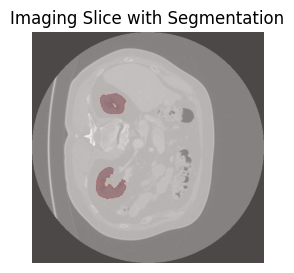

In [38]:
imaging_path = 'data_npy/valid/case_0005/imaging/0080.npy'
segmentation_path = 'data_npy/valid/case_0005/segmentation/0080.npy'
plot_slices(imaging_path, segmentation_path)

In [45]:
from dataset_creator import MyDataset
dataset = MyDataset('valid')

dataset[0][0][0].shape, dataset[0][1][1].shape

(torch.Size([512, 512]), torch.Size([512, 512]))

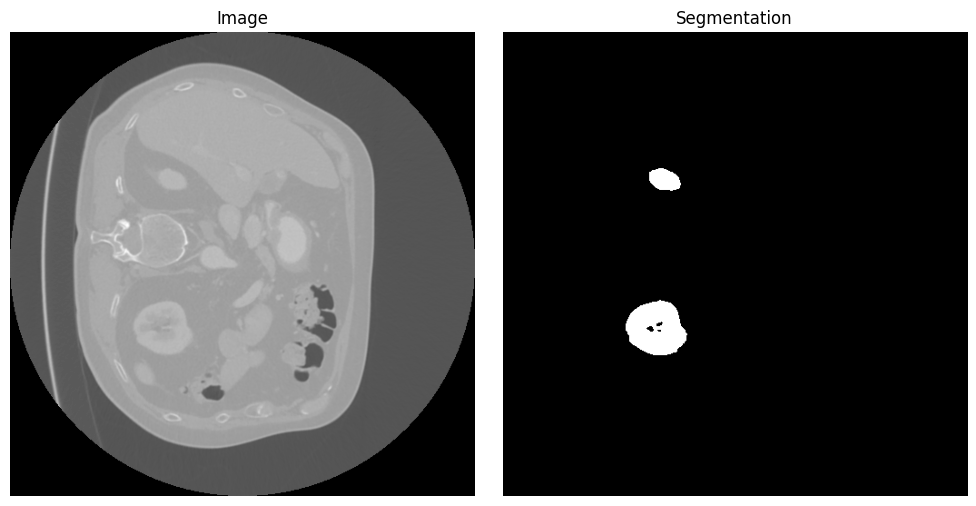

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display dataset[0][0] in the first subplot
axs[0].imshow(dataset[100][0][0], cmap='gray')
axs[0].set_title('Image')

# Display dataset[0][1] in the second subplot
axs[1].imshow(dataset[100][1][1], cmap='gray')
axs[1].set_title('Segmentation')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()
